<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

# Caso 1

In [33]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd


# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns


# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
import warnings
%load_ext autoreload
%autoreload 2


# Configración de warnings
# -----------------------------------------------------------------------
warnings.simplefilter("ignore")

import src.soporte_nlp as sn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
df = pd.read_csv("datos/datos.csv", index_col=0)
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
65115,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
56720,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
26571,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
40292,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
5884,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


In [35]:
df.isnull().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           5
reviewStar            0
reviewText            1
inconsistentStatus    0
dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 65115 to 43619
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            10000 non-null  object 
 1   reviewDate          10000 non-null  object 
 2   mainDepartment      10000 non-null  object 
 3   subDepartment       10000 non-null  object 
 4   productName         10000 non-null  object 
 5   reviewTitle         9995 non-null   object 
 6   reviewStar          10000 non-null  float64
 7   reviewText          9999 non-null   object 
 8   inconsistentStatus  10000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 781.2+ KB


- Eliminamos los 6 nulos que existen porque en comparación con el numero de entradas no nos genera perdida de información significante. Además comprobamos que se han eliminado correctamente.

In [37]:
df.dropna(inplace=True)
df.shape

(9995, 9)

- Comprobamos si existen duplicados

In [38]:
df.duplicated().sum()

np.int64(0)

- No existen duplicados

In [39]:
df["productName"].values[0]

'Doctor Developed Copper Wrist Brace / Carpal Tunnel Wrist Brace / Wrist Support / Wrist Splint / Hand Brace -F.D.A. Class I Medical Device & Doctor Handbook -Night Support for Women & Men -Right & Left hands (Single)'

In [40]:
df.reset_index(inplace=True, drop=True)
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


# Modelo de recomendación basado en contenido

- Descargamos las stopword

In [41]:
nltk.download("stopwords", quiet=True)

True

- Creamos un set con las stopwords en inglés y cargamos nlp con la tokenización en inglés

In [42]:
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")

- Creamos una lambda en el apply con la función para limpiar el texto

In [43]:
df["texto_limpio"] = df["productName"].apply(lambda text: sn.limpiar_texto(text, nlp, stop_words))
df.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,texto_limpio
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1,"[doctor, develop, copper, wrist, brace, carpal..."
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0,"[fruit, loom, men, coolzone, boxer, brief]"
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0,"[tplink, ac750, wifi, extender, re220, cover, ..."
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1,"[gorilla, grip, luxury, chenille, bathroom, ru..."
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0,"[wow, apple, cider, vinegar, shampoo, hair, co..."


- Hacemos un join para limpiar la lista y dejarlo en un unico string

In [44]:
df["texto_limpio"] = df["texto_limpio"].str.join(" ")

In [45]:
df["texto_limpio"].values[0]

'doctor develop copper wrist brace carpal tunnel wrist brace wrist support wrist splint hand brace fda class medical device doctor handbook night support woman man right leave hand single'

- Agrupamos por productName para tener los 99 productos agrupados con todas sus reseñas

In [46]:
df_agrupado = df.groupby("productName")[['mainDepartment', 'subDepartment', 'texto_limpio', 'reviewStar', 'reviewText']].agg(departamento=('mainDepartment', 'first'), subDepartamento=("subDepartment","first"), producto=("texto_limpio","first"), estrellas=("reviewStar","mean"), reseñas=('reviewText', ' '.join))

- Reseteamos el index para reordenar las posiciones

In [47]:
df_agrupado.reset_index(inplace=True)

In [48]:
df_agrupado.head()

,productName,departamento,subDepartamento,producto,estrellas,reseñas
0,"(Refurbished) Apple iPhone 7, 32GB, Black - Fu...",Electronics,CellPhones and Accessories,refurbish apple iphone 7 32 gb black fully unl...,2.912000,I’ll admit I was very skeptical from reviews b...
1,AIMEILI Gel Nail Polish No Wipe Top and Base C...,Beauty and Personal Care,"Foot,Hand & Nail Care",aimeili gel nail polish wipe top base coat set...,3.077419,"It’s thick, but works good once you get used t..."
2,AKASO EK7000 4K30FPS Action Camera Ultra HD Un...,Electronics,Camera and Accessories,akaso ek7000 4k30fps action camera ultra hd un...,2.855932,I was not impressed with the image quality. A...
3,"ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD D...",Computers,Computers & Tablets,asus laptop l210 ultra thin laptop 116 hd disp...,3.049180,The laptop arrived just in time for school!! W...
4,"Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6""...",Computers,Computers & Tablets,acer aspire 5 a51546r14k slim laptop 156 full ...,2.932331,Bought for school work. Doing good so far.Slee...


- Creamos el vetorizador con las stopwords en inglés. Hacemos fit transform de la columna reseñas y posteriormente sacar la similitud entre las palabras.

In [49]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer

CountVectorizer(stop_words='english')

In [50]:
x = vectorizer.fit_transform(df_agrupado["reseñas"]).toarray()
x[:5]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [51]:
similarity = cosine_similarity(x)
similarity[:5]

array([[1.        , 0.2226689 , 0.38635951, 0.35870351, 0.35243796,
        0.5085839 , 0.18552081, 0.14476882, 0.14607118, 0.24248345,
        0.27484731, 0.18105088, 0.22485733, 0.30412029, 0.17525376,
        0.1730754 , 0.18623959, 0.18298615, 0.249053  , 0.19885909,
        0.16525187, 0.1807131 , 0.21990667, 0.27715217, 0.19940101,
        0.38351078, 0.23886942, 0.35472913, 0.19299557, 0.16200401,
        0.25650832, 0.23695757, 0.25169871, 0.41890285, 0.27866033,
        0.20454886, 0.15218421, 0.20320519, 0.31447329, 0.13534728,
        0.17146494, 0.15333024, 0.19504213, 0.26989297, 0.21835127,
        0.1583826 , 0.19282282, 0.34975815, 0.18887017, 0.11262926,
        0.24705777, 0.22223568, 0.26313668, 0.16900299, 0.25087039,
        0.18323017, 0.17377139, 0.81472353, 0.23762583, 0.23484647,
        0.20569355, 0.22680309, 0.18243539, 0.29252407, 0.22764655,
        0.25600152, 0.20705752, 0.26529732, 0.20509138, 0.31929359,
        0.29718729, 0.37206819, 0.19554236, 0.42

- Extraemos un producto para probarlo

In [52]:
df_agrupado["productName"].iloc[0]

'(Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked'

In [53]:
user_like_product = df_agrupado["productName"].iloc[0]

- Utilizamos las fuciones del src para extraer el index pasandole el nombre del producto. Comprobamos las similitudes a través del index. Enumeramos las coincidencias en una lista y ordenamos.

In [54]:
product_index = sn.get_index_from_name(df_agrupado, user_like_product)
product_index

np.int64(0)

In [55]:
similarity[product_index][:20]

array([1.        , 0.2226689 , 0.38635951, 0.35870351, 0.35243796,
       0.5085839 , 0.18552081, 0.14476882, 0.14607118, 0.24248345,
       0.27484731, 0.18105088, 0.22485733, 0.30412029, 0.17525376,
       0.1730754 , 0.18623959, 0.18298615, 0.249053  , 0.19885909])

In [56]:
simillar_products = list(enumerate(similarity[product_index]))
simillar_products[:10]

[(0, np.float64(0.9999999999999998)),
 (1, np.float64(0.2226688992372565)),
 (2, np.float64(0.3863595100980089)),
 (3, np.float64(0.3587035122730526)),
 (4, np.float64(0.3524379620723738)),
 (5, np.float64(0.5085839033528518)),
 (6, np.float64(0.18552081266200066)),
 (7, np.float64(0.1447688190082909)),
 (8, np.float64(0.1460711831617506)),
 (9, np.float64(0.24248344822521567))]

In [57]:
sorted_product = sorted(simillar_products, key=lambda x: x[1], reverse=True)
sorted_product[:10]

[(0, np.float64(0.9999999999999998)),
 (57, np.float64(0.8147235311272294)),
 (85, np.float64(0.5118133006089851)),
 (5, np.float64(0.5085839033528518)),
 (81, np.float64(0.46872195775435266)),
 (73, np.float64(0.42539574728302026)),
 (33, np.float64(0.4189028455219861)),
 (87, np.float64(0.40971902237957974)),
 (2, np.float64(0.3863595100980089)),
 (25, np.float64(0.3835107773318486))]

- Extraemos el top 10 productos que más se parecen al que le hemos pasado

In [58]:
top_products = {}
for i in sorted_product[1:11]:
    top_products[sn.get_name_from_index(df_agrupado, i[0])] = i[1]
top_products

{'Moto G Power | 3-Day Battery1 | Unlocked | Made for US by Motorola | 4/64GB | 16MP Camera | 2020 | Black': np.float64(0.8147235311272294),
 'Tile Pro (2020) 1-pack - High Performance Bluetooth Tracker, Keys Finder and Item Locator for Keys, Bags, and More; 400 ft Range, Water Resistance and 1 Year Replaceable Battery': np.float64(0.5118133006089851),
 'Ailun Glass Screen Protector Compatible for iPhone 11/iPhone XR, 6.1 Inch 3 Pack Tempered Glass': np.float64(0.5085839033528518),
 'TOZO T6 True Wireless Earbuds Bluetooth Headphones Touch Control with Wireless Charging Case IPX8 Waterproof Stereo Earphones in-Ear Built-in Mic Headset Premium Deep Bass for Sport Black': np.float64(0.46872195775435266),
 'Samsung Galaxy Buds Plus, True Wireless Earbuds (Wireless Charging Case Included), Black – US Version': np.float64(0.42539574728302026),
 'Garmin 010-02064-00 Instinct, Rugged Outdoor Watch with GPS, Features Glonass and Galileo, Heart Rate Monitoring and 3-Axis Compass, Graphite': np.

- Visualización del top 10 productos más relacionados

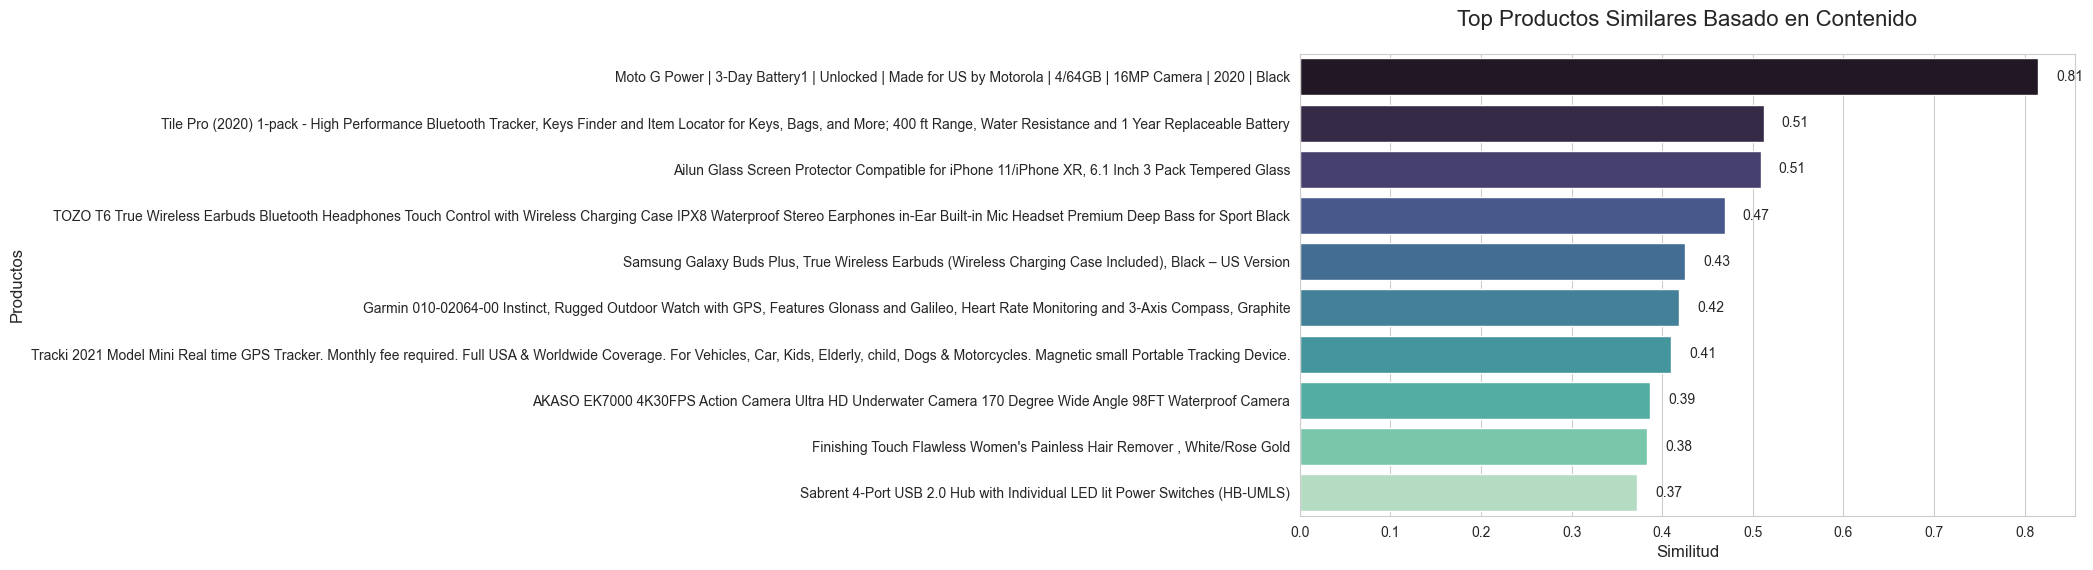

In [59]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(top_products.values()),
    y=list(top_products.keys()),
    palette="mako"
)

plt.title("Top Productos Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Productos", fontsize=12)

for i, value in enumerate(top_products.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()